In [1]:
pip install bokeh

Note: you may need to restart the kernel to use updated packages.


In [247]:
import cv2
import time

import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

<IPython.core.display.Javascript object>


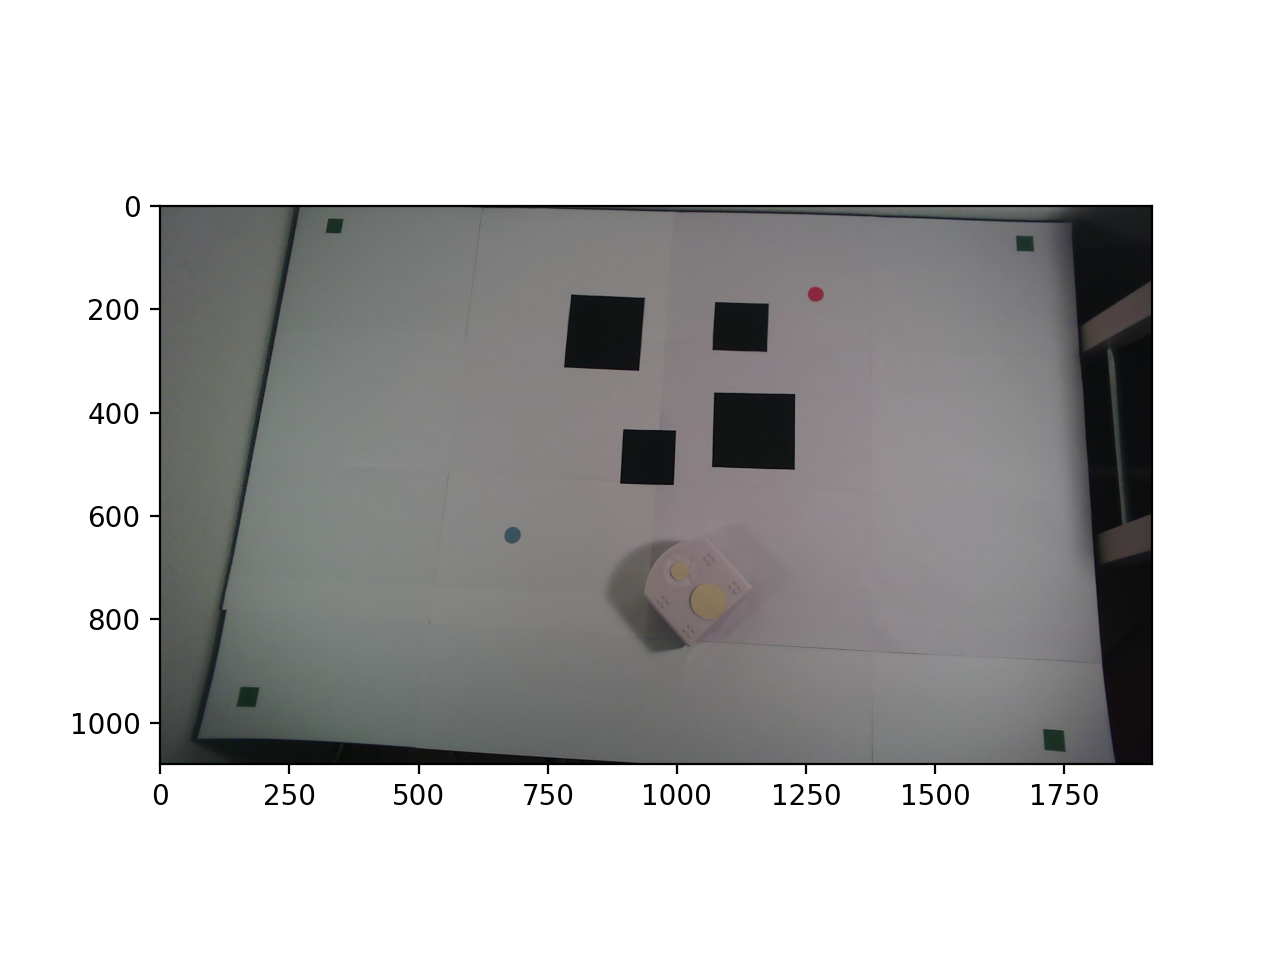

In [248]:
img = cv2.imread('map.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure()
plt.imshow(img)

<IPython.core.display.Javascript object>


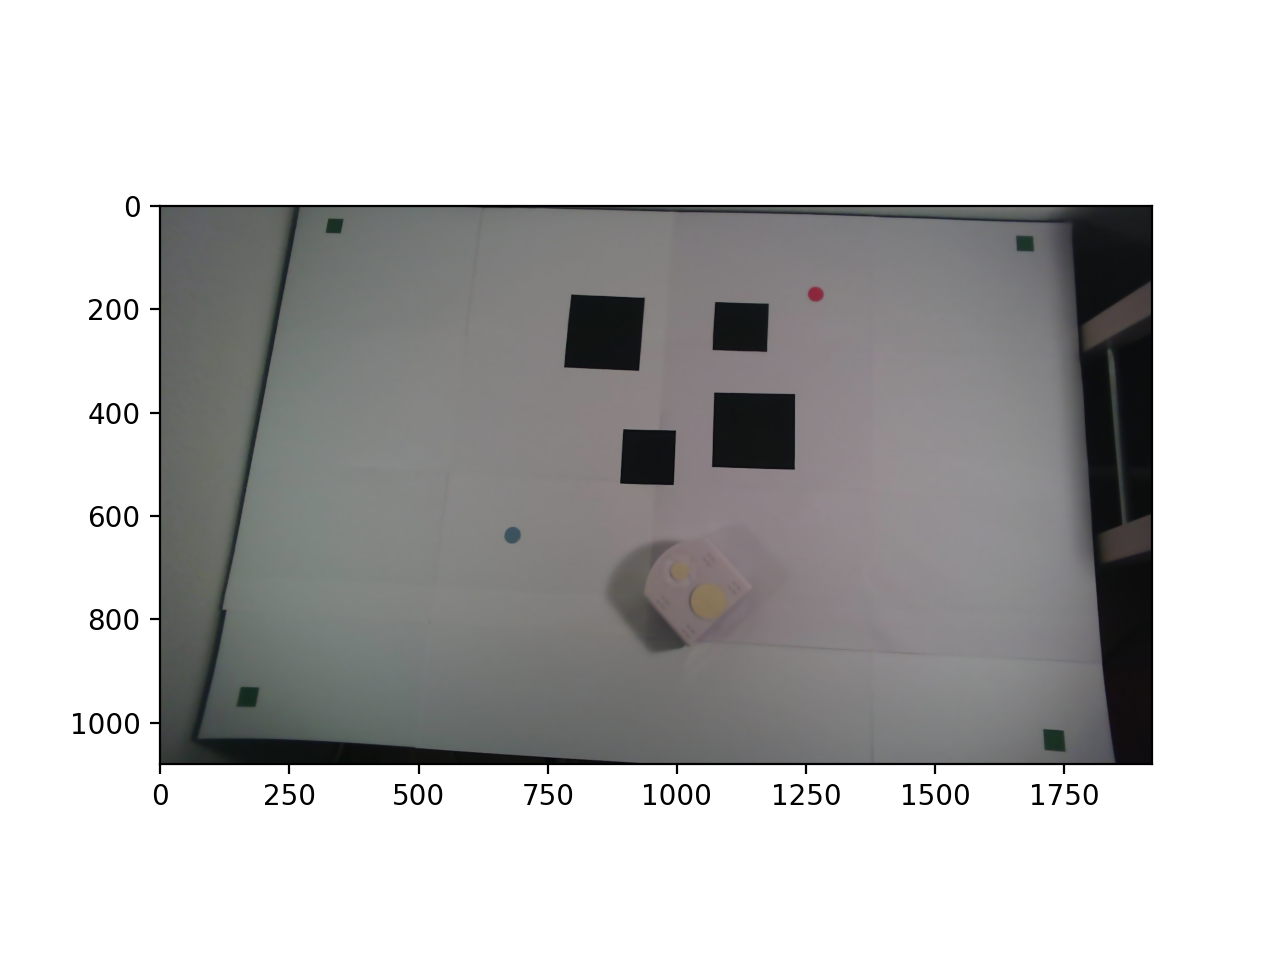

In [249]:
bilateral = cv2.bilateralFilter(img,9,75,75)
plt.figure()
plt.imshow(bilateral)

In [250]:
img_goal = bilateral.copy()
img_coin = bilateral.copy()

(1268.97216796875, 170.19444274902344)


<IPython.core.display.Javascript object>


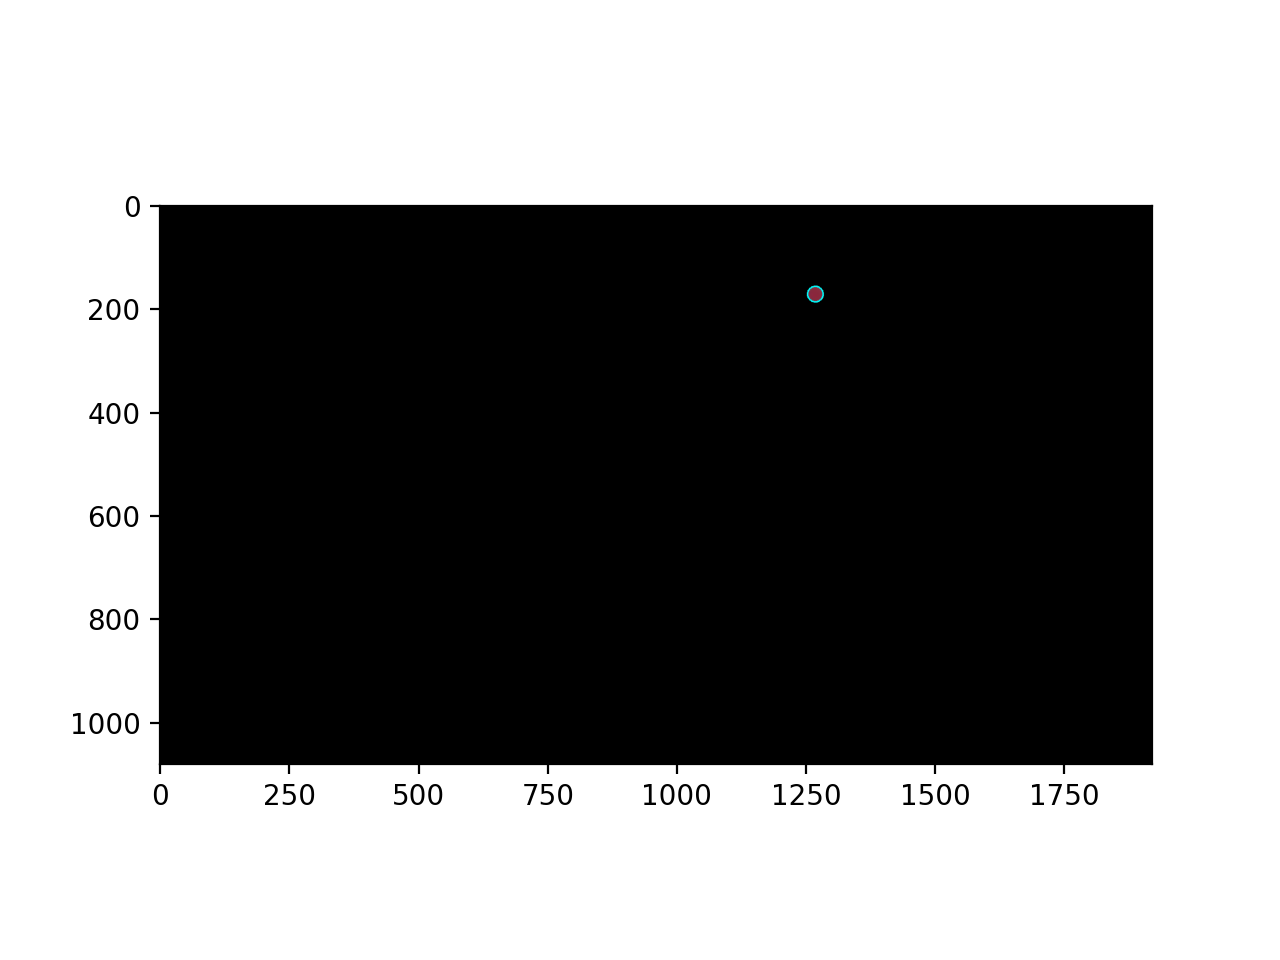

In [251]:
#Repere goal ==> (x,y) = centre du goal
green_lower=np.array([170,50,50])
green_upper=np.array([240,255,255])
color_infos = (0,255,255)

img_hsv = cv2.cvtColor(img_goal, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, green_lower, green_upper)
img_hsv = cv2.blur(img_hsv,(7,7))
mask = cv2.erode(mask, None, iterations = 4)
mask = cv2.dilate(mask, None, iterations = 4)
image2 = cv2.bitwise_and(img_goal, img_goal, mask=mask)
elements = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
if len(elements) > 0:
    c = max(elements, key=cv2.contourArea)
    ((x,y),rayon) = cv2.minEnclosingCircle(c)
    if rayon>0:
        cv2.circle(image2,(int(x),int(y)), int(rayon), color_infos, 2)
        cv2.circle(img_goal,(int(x),int(y)), 5, color_infos, 10)
        cv2.line(img_goal,(int(x),int(y)), (int(x)+150,int(y)), color_infos, 2)
print((x,y))
plt.figure()
plt.imshow(image2)
plt.show()

1
(1679.0439453125, 72.68892669677734)


<IPython.core.display.Javascript object>


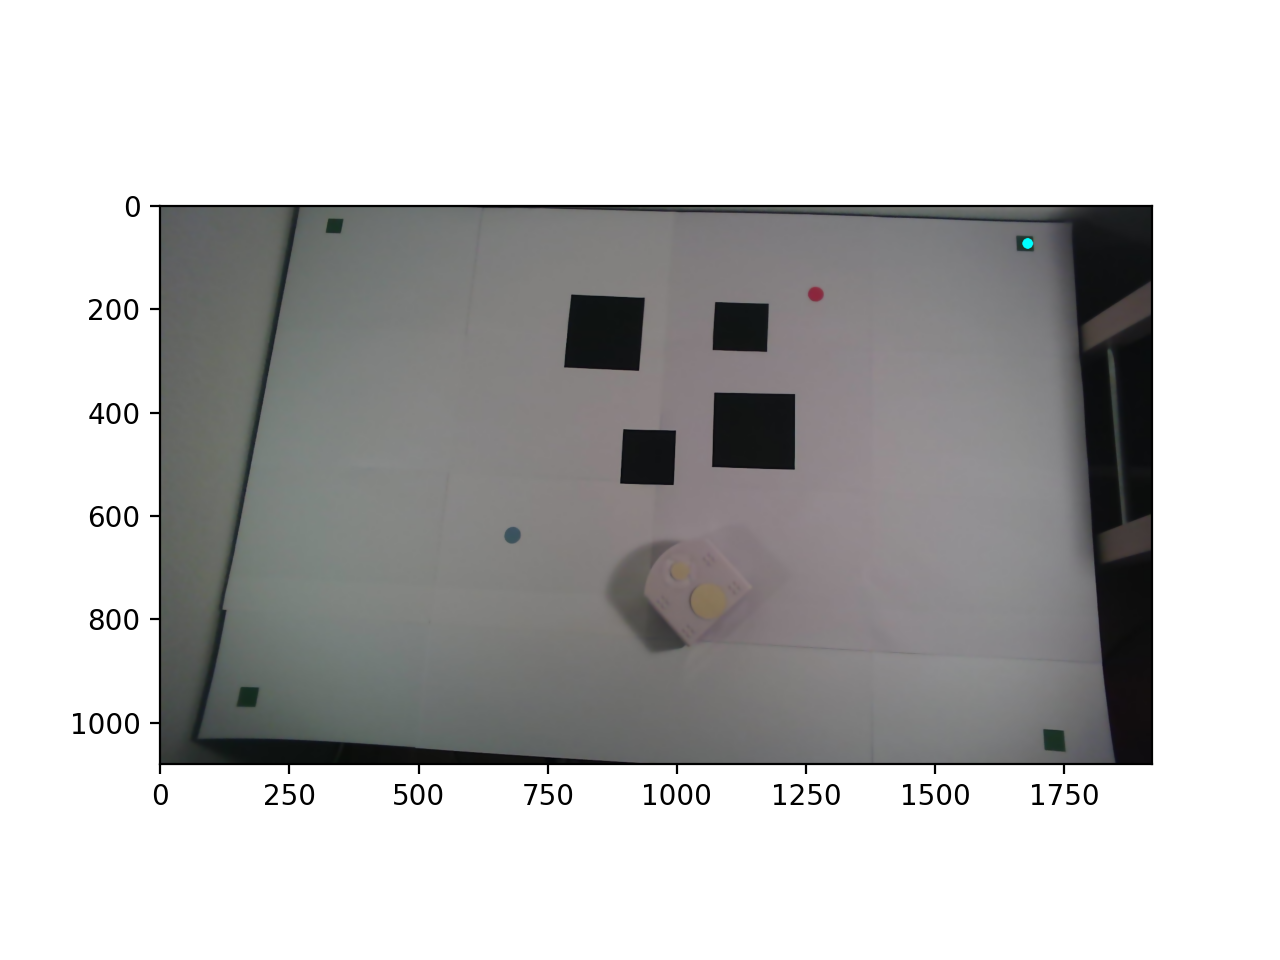

In [252]:
#Repere coin ==> (x,y) = centre des coins
green_lower=np.array([30,50,50])
green_upper=np.array([80,255,255])
color_infos = (0,255,255)

img_hsv = cv2.cvtColor(img_goal, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, green_lower, green_upper)
img_hsv = cv2.blur(img_hsv,(7,7))
mask = cv2.erode(mask, None, iterations = 4)
mask = cv2.dilate(mask, None, iterations = 4)
image2 = cv2.bitwise_and(img_coin, img_coin, mask=mask)
elements,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area = cv2.contourArea(elements[0])
print(len(elements))
if len(elements) > 0:
    for i in range(0,len(elements)):
        c = elements[i] 
        ((x,y),rayon) = cv2.minEnclosingCircle(c)
        if rayon>0:
            cv2.circle(image2,(int(x),int(y)), int(rayon), color_infos, 2)
            cv2.circle(img_coin,(int(x),int(y)), 5, color_infos, 10)
            #cv2.line(img_goal,(int(x),int(y)), (int(x)+150,int(y)), color_infos, 2)
        print((x,y))
plt.figure()
plt.imshow(img_coin)
plt.show()

In [253]:
def detect_coin(imgRGB):
    coord = []
    green_lower=np.array([30,50,50])
    green_upper=np.array([80,255,255])
    color_infos = (0,255,255)
    img_hsv = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, green_lower, green_upper)
    img_hsv = cv2.blur(img_hsv,(7,7))
    mask = cv2.erode(mask, None, iterations = 4)
    mask = cv2.dilate(mask, None, iterations = 4)
    #image2 = cv2.bitwise_and(imgRGB, imgRGB, mask=mask)
    elements,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(elements))
    if len(elements) > 0:
        for i in range(0,len(elements)):
            c = elements[i] 
            ((x,y),rayon) = cv2.minEnclosingCircle(c)
            coord.append((x,y))
            if rayon>0:
                cv2.circle(imgRGB,(int(x),int(y)), int(rayon), color_infos, 2)
    return coord

In [254]:
coord = detect_coin(img_coin)
print(coord)

0
[]


In [218]:
coords_sorted =order_points(coord)
print(coords_sorted)
(tl, tr, br, bl) = coords_sorted
print(np.array(tl))

[(398.0, 35.0), (1216.0, 50.53571319580078), (1239.0, 50.0), (1240.5, 69.38888549804688), (1216.0, 72.0), (1351.0, 969.0), (300.5, 1023.5)]


ValueError: too many values to unpack (expected 4)

(220.0, 51.5) (1430.5, 89.0) (77.5, 1492.0) (1608.0, 1411.5)
1949 1532


<IPython.core.display.Javascript object>


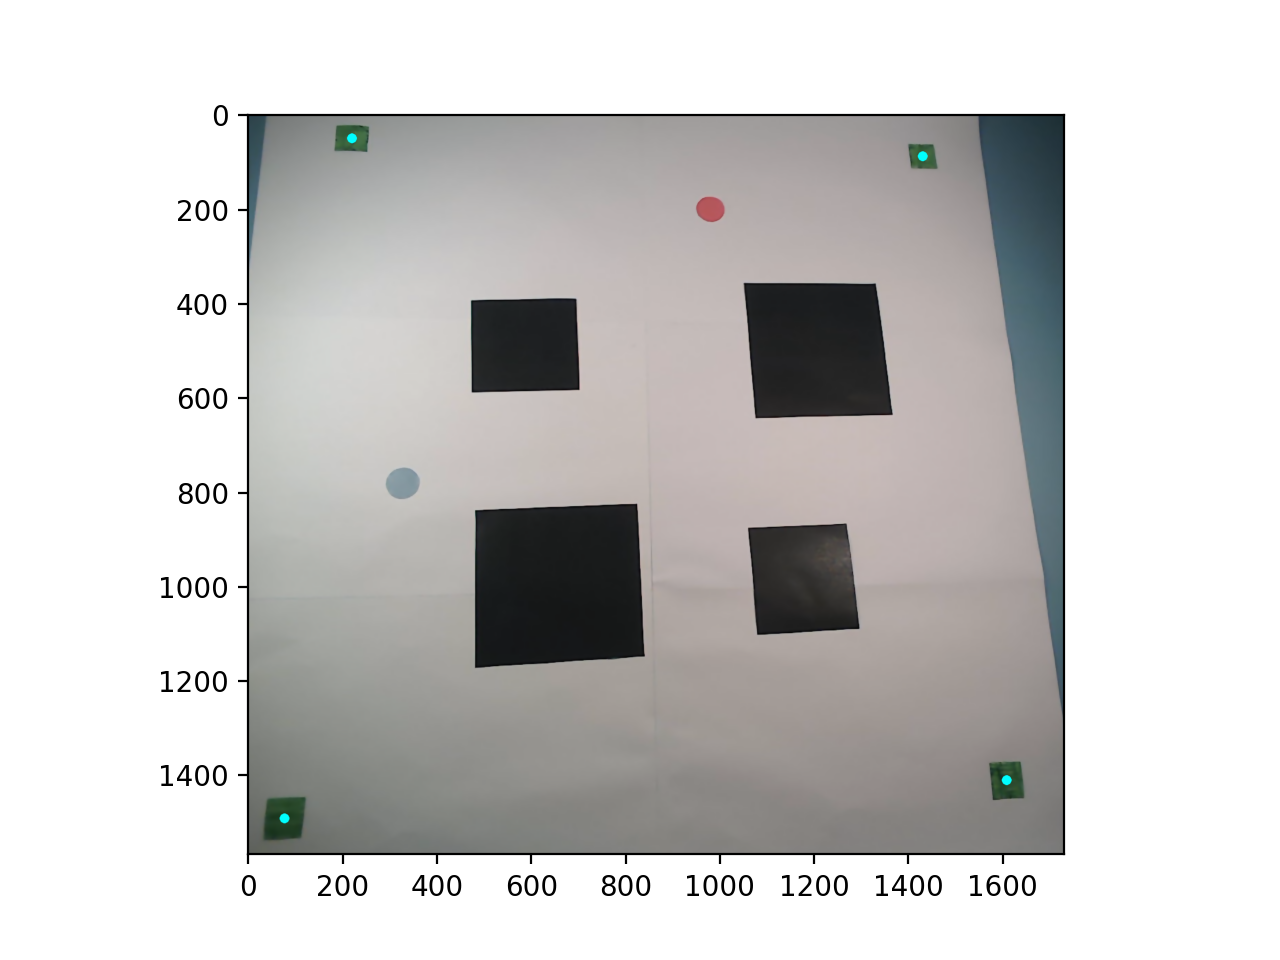

In [206]:
imgcal = img_calibration(img_coin)
plt.figure()
plt.imshow(imgcal)
plt.show()

(220.0, 51.5) (1430.5, 89.0) (77.5, 1492.0) (1608.0, 1411.5)
1949 1532


<IPython.core.display.Javascript object>


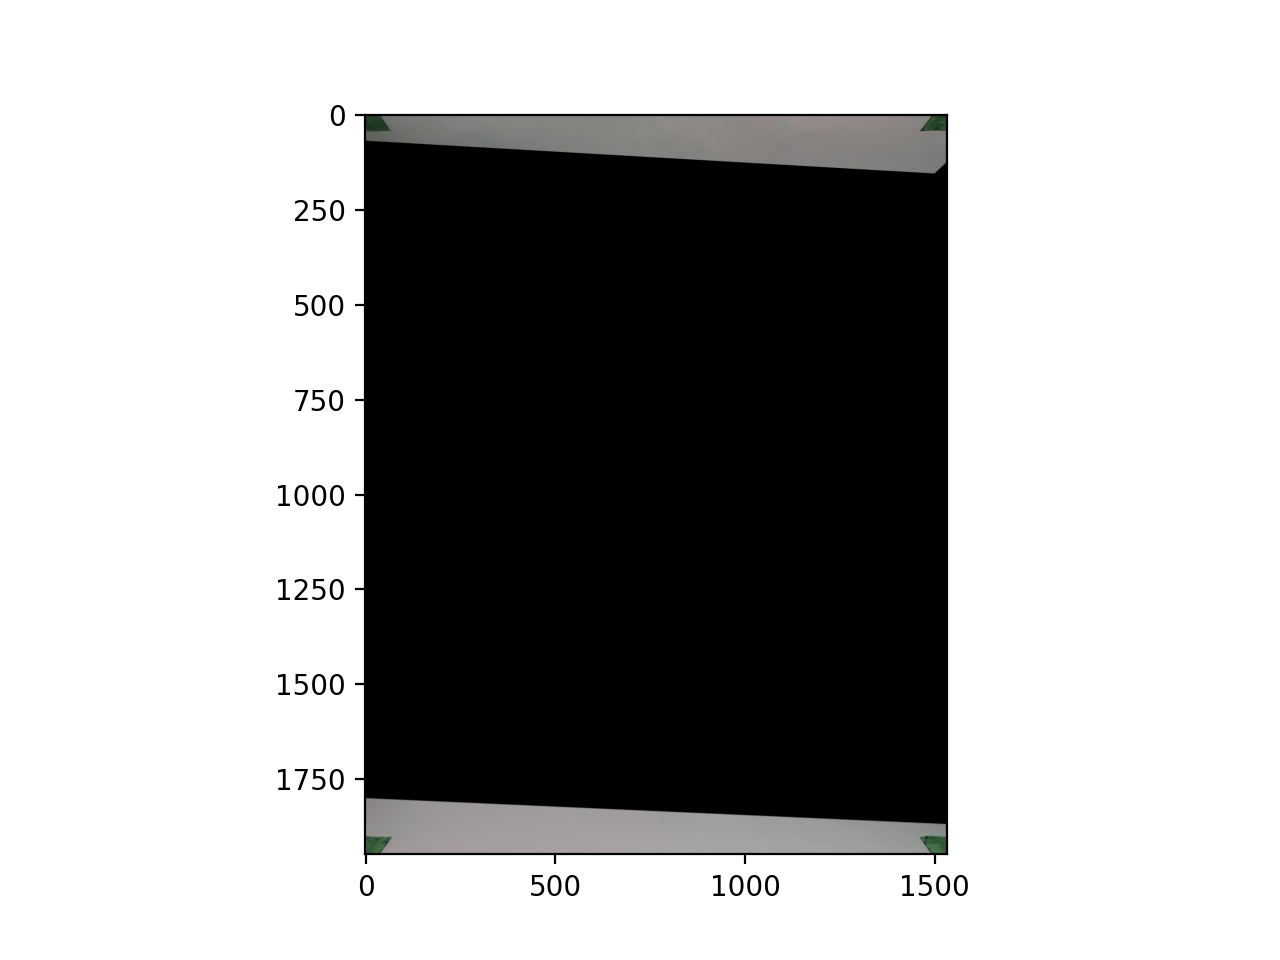

In [208]:
img_test = img_coin.copy()
wraped = four_point_transform(img_coin, coords_sorted)
plt.figure()
plt.imshow(wraped)
plt.show()

In [190]:
def order_points(pts):
    """
    # initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect
    """
     #sorting points first by the 2nd the coordinate then 1st coordinate
    pts=sorted(pts, key=lambda x: (int(x[1]), int(x[0]))) #topleft,topright,bottomleft,bottomright
    #vérification du sorting et intervertit si il y a eu une erreur
    #top left x > top right x => erreur et intervertit
    if pts[0][0] > pts[1][0]:
        pts[0], pts[1] = pts[1], pts[0]
    if pts[2][0] > pts[3][0]:
        pts[2], pts[3] = pts[3], pts[2]
    return pts


def four_point_transform(image, ordered_pts):	# obtain a consistent order of the points and unpack them
    # individually
    (tl, tr, br, bl) = ordered_pts
    pt_C = np.array(tl) #ptA
    pt_B = np.array(tr) #ptD
    pt_A = np.array(br) #ptC
    pt_D = np.array(bl) #ptB
    print(tl,tr,br,bl)
    
    
    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    print(maxHeight, maxWidth)

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    #widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    #widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    #maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    #heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    #heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    #maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    #input_pts = np.float32([tl, bl, br, tr])
    #dst = np.float32([[0, 0],[maxWidth - 1, 0],[maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]])
    
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(input_pts, output_pts)
    out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
    #warped = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

    #warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return out


def img_calibration(img):
    
    corner_points = detect_coin(img_goal)
    if len(corner_points) != 4:
        print("failure in identifying corners")
        print(corner_points)
    corner_points=order_points(corner_points)
    warpedimg=four_point_transform(img,corner_points)
    # Showing the image along with outlined arrow.
    #cv2.imshow('image2', img2) 
    #cv2.imwrite('lignes_red.png', img2)
        
    plt.imshow(img)
    return img

<IPython.core.display.Javascript object>


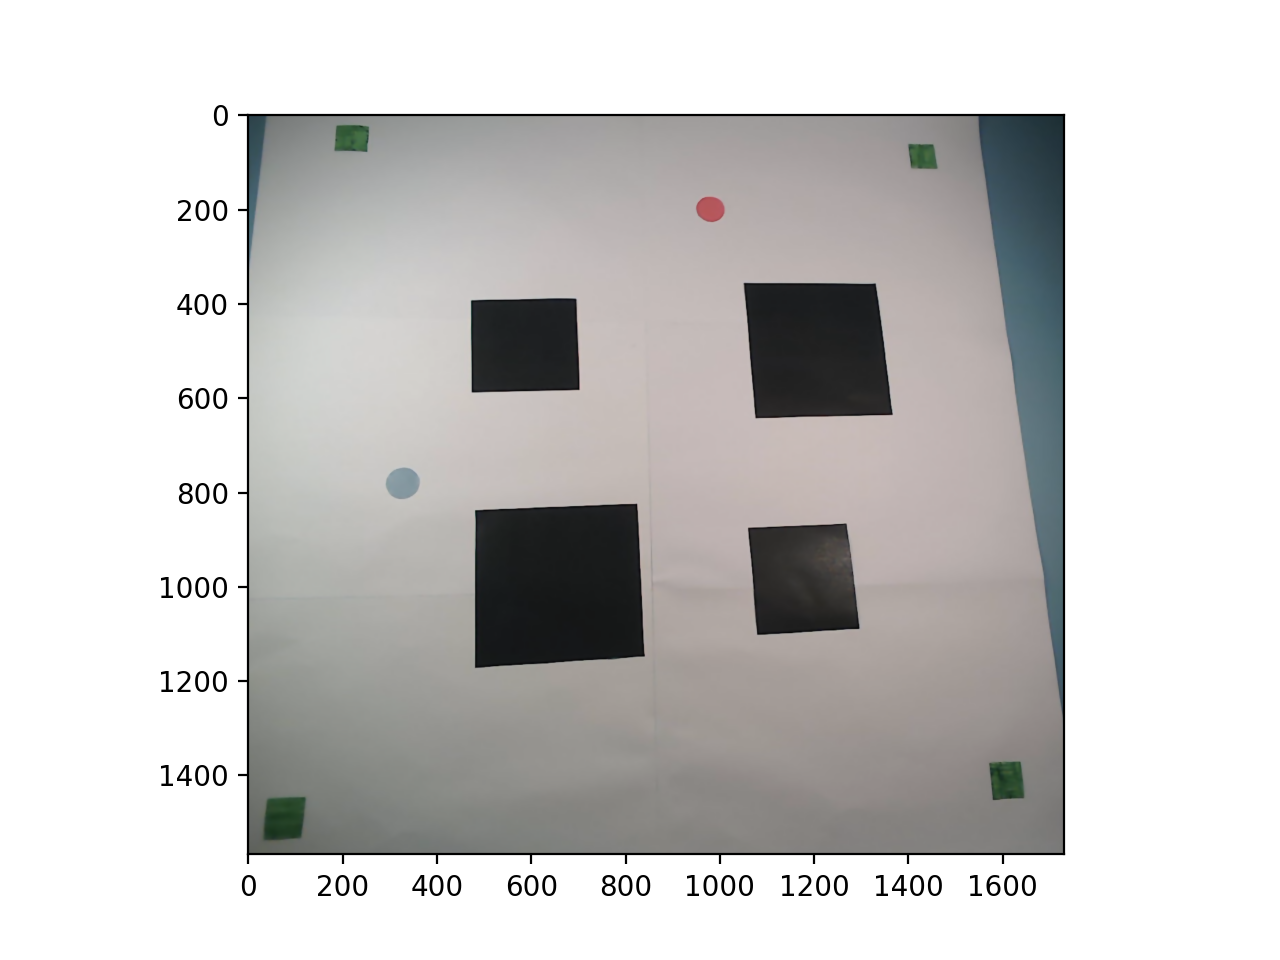

In [170]:
imgcal = img_calibration(img_coin)
plt.figure()
plt.imshow(imgcal)
plt.show()